In [32]:
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.algorithms.preprocessing.distributional_repair import DistributionalRepair
from aif360.datasets import AdultDataset
import numpy as np
import pandas as pd
import ot
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


In [33]:
def load_adult_dataset():
    def custom_preprocessing(df):
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name="Income Binary",
        favorable_classes=[1,1],
        protected_attribute_names=['sex','race'],
        privileged_classes=[[1.0], [1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=['age', 'sex','college_educated', 'education-num', 'hours-per-week', 'race', 'fnlwgt'],
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

data = load_adult_dataset()

C:\Users\01joh\AppData\Local\Temp\ipykernel_51132\307300434.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)


In [34]:

n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

train_frac = 1.0 # proportion of research data to train classifier with


In [35]:
s = 'sex'
u = 'college_educated'
x = ['age','education-num','hours-per-week']
y = 'Income Binary'

continuous_features = ['age','hours-per-week']

In [46]:
def splitDataset(dataset, s,u,x,y,n_R):
    np.random.seed(0)
    R_idx = np.random.permutation(dataset.index)

    s_R = dataset.loc[R_idx[:n_R], s]
    u_R = dataset.loc[R_idx[:n_R], u]
    x_R = dataset.loc[R_idx[:n_R], x]
    y_R = dataset.loc[R_idx[:n_R], y]

    s_A = dataset.loc[R_idx[n_R:], s]
    u_A = dataset.loc[R_idx[n_R:], u]
    x_A = dataset.loc[R_idx[n_R:], x]
    y_A = dataset.loc[R_idx[n_R:], y]

    return s_R, u_R, x_R, y_R, s_A, u_A, x_A, y_A

s_R, u_R, x_R, y_R, s_A, u_A, x_A, y_A = splitDataset(data.convert_to_dataframe()[0], s, u, x, y, n_R)

KeyError: "None of [Index([52.0, 16.0, 40.0], dtype='float64')] are in the [columns]"

In [37]:
tilde_x_R_pt = x_R.copy()
tilde_x_R = x_R.copy()
tilde_x_A = x_A.copy()

for u_val in data.convert_to_dataframe()[0][u].unique():
    print(f"Repairing u = {u_val}")
    for feat in x_R.columns:
        continuous = feat in continuous_features
        print(f"Repairing feature {feat}, continuous = {continuous}")
        d = DistributionalRepair()
        d.fit(s_R, u_R, x_R, feat, n_q, u_val, continuous)
        tilde_x_A, tilde_x_R = d.transform(s_R, u_R, x_R, feat, s_A, u_A, x_A, tilde_x_R, tilde_x_A, u_val,continuous)

    M = ot.dist(x_R[(u_R == u_val) & (s_R == 0)].values, x_R[(u_R == u_val) & (s_R == 1)].values)
    n_0 = int(len(x_R[(u_R == u_val) & (s_R == 0)]))
    n_1 = int(len(x_R[(u_R == u_val) & (s_R == 1)]))

    T = ot.emd(np.ones(n_0)/n_0, np.ones(n_1)/n_1, M)
    for i, (pd_idx, x) in enumerate(x_R[(u_R == u_val) & (s_R == 0)].iterrows()):
        row = T[i,:]
        row /= np.sum(row)
        tilde_x_R_pt.loc[pd_idx, :] = 0.5 * x.values + 0.5 * row @ x_R[(u_R == u_val) & (s_R == 1)].values

    for j, (pd_idx, x) in enumerate(x_R[(u_R == u_val) & (s_R == 1)].iterrows()):
        col = T[:,j]
        col /= np.sum(col)
        tilde_x_R_pt.loc[pd_idx, :] = 0.5 * x.values + 0.5 * col @ x_R[(u_R == u_val) & (s_R == 0)].values    

Repairing u = 0.0
Repairing feature age, continuous = True


Repairing feature education-num, continuous = False
Repairing feature hours-per-week, continuous = True
Repairing u = 1.0
Repairing feature age, continuous = True
Repairing feature education-num, continuous = False
Repairing feature hours-per-week, continuous = True


In [38]:
data.convert_to_dataframe()[0].head()

,age,fnlwgt,education-num,race,sex,hours-per-week,college_educated,Income Binary
0,25.0,226802.0,7.0,0.0,1.0,40.0,0.0,0.0
1,38.0,89814.0,9.0,1.0,1.0,50.0,0.0,0.0
2,28.0,336951.0,12.0,1.0,1.0,40.0,1.0,1.0
3,44.0,160323.0,10.0,0.0,1.0,40.0,1.0,1.0
4,18.0,103497.0,10.0,1.0,0.0,30.0,1.0,0.0


In [39]:
data.convert_to_dataframe()[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 48841
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               48842 non-null  float64
 1   fnlwgt            48842 non-null  float64
 2   education-num     48842 non-null  float64
 3   race              48842 non-null  float64
 4   sex               48842 non-null  float64
 5   hours-per-week    48842 non-null  float64
 6   college_educated  48842 non-null  float64
 7   Income Binary     48842 non-null  float64
dtypes: float64(8)
memory usage: 3.4+ MB


In [40]:
x_R.head()

,age,education-num,hours-per-week
38113,36.0,13.0,40.0
39214,57.0,15.0,36.0
44248,49.0,14.0,45.0
10283,54.0,3.0,55.0
26724,17.0,6.0,24.0


In [41]:
tilde_x_R.head()

,age,education-num,hours-per-week
38113,33.271084,13.0,38.901205
39214,55.434940,14.0,28.983133
44248,46.991566,14.0,43.151807
10283,54.379518,3.0,49.763855
26724,16.384337,4.0,29.927711


In [42]:
def eval_labels(Y, S, S_set=[0,1]):
    eval_dict = {}
    eval_dict['di'] = np.sum(Y[S == S_set[0]]) / np.sum(Y[S == S_set[1]])
    return eval_dict

def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)

    kde_0 = KernelDensity(kernel='gaussian').fit(x_0.values.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support))
    kde_1 = KernelDensity(kernel='gaussian').fit(x_1.values.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))

    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        if (len(x[(u == u_val) & (s == 0)]) == 0) or (len(x[(u == u_val) & (s == 1)]) == 0):
            continue
        tmp = _eval_kld(*[x[(u == u_val) & (s == s_val)] for s_val in order])
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)

    return tot_kld

In [43]:
feats = ['age', 'hours-per-week']

[0.38292142 0.85524445]
[0.0186931  3.32285599]
[0.00504739 0.29468322]


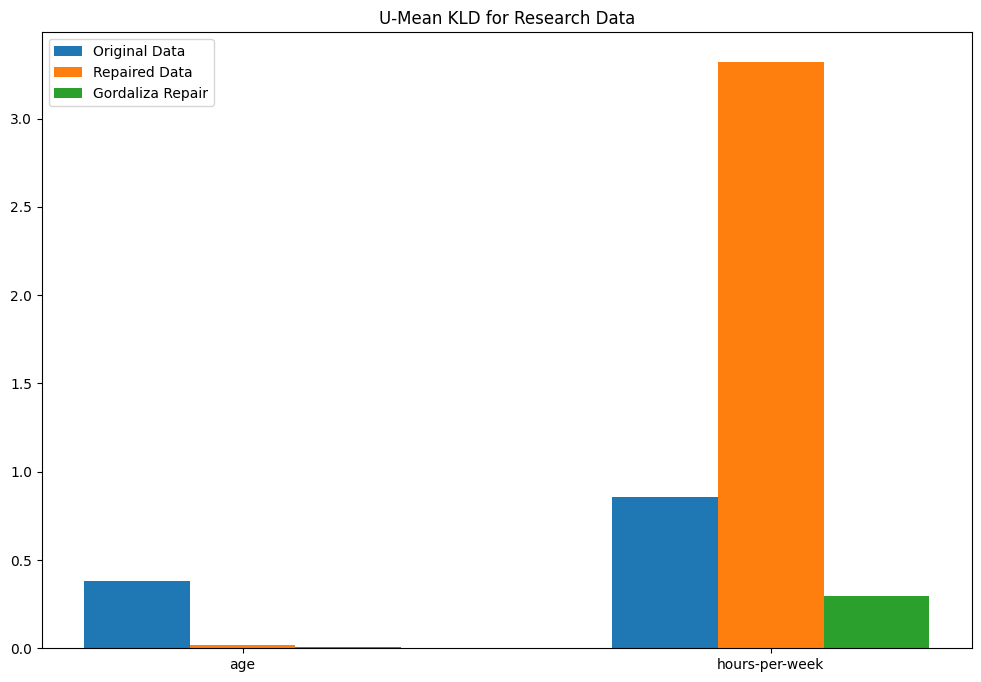

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
kld_x = np.zeros(shape=(len(feats), 2))
kld_x_tilde = np.zeros(shape=(len(feats), 2))
kld_x_tilde_pt = np.zeros(shape=(len(feats), 2))

bar_width = 0.2
pos = np.arange(len(feats))

for i, feat in enumerate(feats):
    kld_x[i, 0] = eval_kld(x_R[feat], s_R, u_R, order=[0, 1])
    kld_x[i, 1] = eval_kld(x_R[feat], s_R, u_R, order=[1, 0])
    kld_x_tilde[i, 0] = eval_kld(tilde_x_R[feat], s_R, u_R, order=[0, 1])
    kld_x_tilde[i, 1] = eval_kld(tilde_x_R[feat], s_R, u_R, order=[1, 0])
    kld_x_tilde_pt[i, 0] = eval_kld(tilde_x_R_pt[feat], s_R, u_R, order=[0, 1])
    kld_x_tilde_pt[i, 1] = eval_kld(tilde_x_R_pt[feat], s_R, u_R, order=[1, 0])

ax.bar(x=pos - bar_width, height=np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))), width=bar_width, alpha=1, label='Original Data')
ax.bar(x=pos, height=np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))), width=bar_width, alpha=1, label='Repaired Data')
ax.bar(x=pos + bar_width, height=np.mean(kld_x_tilde_pt, axis=1, where=~(np.isinf(kld_x_tilde_pt))), width=bar_width, alpha=1, label='Gordaliza Repair')

ax.set_xticks(pos)
ax.set_xticklabels(feats)
ax.set_title('U-Mean KLD for Research Data')
ax.legend()

print(np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))))
print(np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))))
print(np.mean(kld_x_tilde_pt, axis=1, where=~(np.isinf(kld_x_tilde_pt))))

[0.32582157 0.92075706]
[0.05953857 3.35781738]


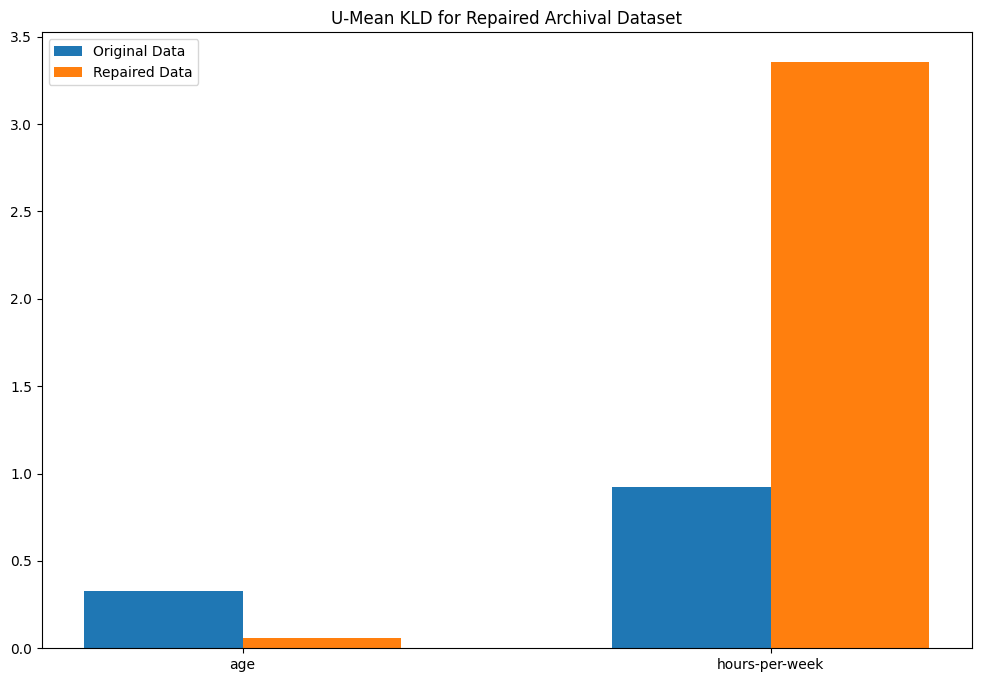

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
kld_x = np.zeros(shape=(len(feats), 2))
kld_x_tilde = np.zeros(shape=(len(feats), 2))

bar_width = 0.3
pos = np.arange(len(feats))

for i, feat in enumerate(feats):
    kld_x[i, 0] = eval_kld(x_A[feat], s_A, u_A, order=[0, 1])
    kld_x[i, 1] = eval_kld(x_A[feat], s_A, u_A, order=[1, 0])
    kld_x_tilde[i, 0] = eval_kld(tilde_x_A[feat], s_A, u_A, order=[0, 1])
    kld_x_tilde[i, 1] = eval_kld(tilde_x_A[feat], s_A, u_A, order=[1, 0])

ax.bar(x=pos - bar_width/2, height=np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))), width=bar_width, alpha=1, label='Original Data')
ax.bar(x=pos + bar_width/2, height=np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))), width=bar_width, alpha=1, label='Repaired Data')

ax.set_xticks(pos)
ax.set_xticklabels(feats)
ax.set_title('U-Mean KLD for Repaired Archival Dataset')
ax.legend()

print(np.mean(kld_x, axis=1, where=~(np.isinf(kld_x))))
print(np.mean(kld_x_tilde, axis=1, where=~(np.isinf(kld_x_tilde))))